In [10]:
# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Common imports and settings
import os, sys
os.environ['USE_PYGEOS'] = '0'
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr

# Datacube
import datacube
from datacube.utils.rio import configure_s3_access
from datacube.utils import masking
from datacube.utils.cog import write_cog
# https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
from dea_tools.plotting import display_map, rgb
from dea_tools.datahandling import mostcommon_crs

# EASI defaults
easinotebooksrepo = '/home/jovyan/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import EasiDefaults, xarray_object_size, notebook_utils, load_s2l2a_with_offset_patch

In [11]:
# Data tools
import numpy as np
from datetime import datetime

# Datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_masking.py
from odc.algo import xr_reproject   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_warp.py
from datacube.utils.geometry import GeoBox, box  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/geometry/_base.py

# Holoviews, Datashader and Bokeh
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
import joblib
from utils import load_data_geo
# import geoviews as gv
# from holoviews.operation.datashader import rasterize
hv.extension('bokeh', logo=False)

In [12]:
# Dask gateway

cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
client

Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.b783f7f9983d425a9693ad1fec481c6c/status,


In [13]:
dc = datacube.Datacube()

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [14]:
thuanhoa_path = "ThuanHoa/region/ThuanHoa_rectangle_biggersize.shp"
thuanhoa_region = load_data_geo(thuanhoa_path)
thuanhoa_region.head()

,id,geometry
0,1,"POLYGON ((594967.521 1066908.066, 594967.521 1..."


In [15]:
# import geopandas as gpd
# gdf = gpd.read_file(thuanhoa_path)
# gdf_4326 = gdf.to_crs(epsg=4326)
# lat_range = (gdf_4326.total_bounds[1], gdf_4326.total_bounds[3])
# lon_range = (gdf_4326.total_bounds[0], gdf_4326.total_bounds[2])

In [72]:
from deafrica_tools.bandindices import calculate_indices
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Vietnam
min_longitude, max_longitude = (105.86575, 105.94120)
min_latitude, max_latitude = (9.65070, 9.69850)
min_date = '2022-09-01' # Start time
max_date = '2023-10-01' # End time
product = 's2_l2a'

query1 = {
    'product': product,                     # Product name
    'x': (min_longitude, max_longitude),    # "x" axis bounds
    'y': (min_latitude, max_latitude),      # "y" axis bounds
    'time': (min_date, max_date),           # Any parsable date strings
}

# Most common CRS
native_crs = notebook_utils.mostcommon_crs(dc, query1)

query1.update({
    'measurements': ['blue', 'green', 'red', 'nir', 'scl'],  # Selected measurement bands
    'output_crs': native_crs,               # EPSG code
    'resolution': (-10, 10),                # Target resolution
    'group_by': 'solar_day',                # Scene ordering
    'dask_chunks': {'x': 3310, 'y': 3000},  # Dask chunks
})

In [74]:
# Load data
data = dc.load(**query1)

# data = load_s2l2a_with_offset_patch(dc, query1)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

# Calculate valid (not nodata) masks for each layer
valid_mask = masking.valid_data_mask(data)
notebook_utils.heading('Valid data masks for each variable')
display(valid_mask)

<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) bool dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    green        (time, y, x) bool dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    red          (time, y, x) bool dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) bool dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) bool dask.array<chunksize=(1, 532, 830), meta=np.ndarray>

In [75]:
# Get the scale factor and offset from the measurement metadata

measurement_info = dc.list_measurements().loc[query1['product']].loc[query1['measurements']]  # Pandas dataframe
display(measurement_info)

# The "SCL" band contains quality flags and information. The details can also be found in the metadata.

flag_name = 'scl'
flag_desc = masking.describe_variable_flags(data[flag_name])  # Pandas dataframe
display(flag_desc)
display(flag_desc.loc['qa'].values[1])

,name,dtype,units,nodata,flags_definition,aliases,add_offset,scale_factor
measurement,,,,,,,,
blue,blue,uint16,1,0,NaN,"[band_02, B02]",-0.1,0.0001
green,green,uint16,1,0,NaN,"[band_03, B03]",-0.1,0.0001
red,red,uint16,1,0,NaN,"[band_04, B04]",-0.1,0.0001
nir,nir,uint16,1,0,NaN,"[band_08, B08, nir_1]",-0.1,0.0001
scl,scl,uint8,1,0,"{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...","[SCL, mask, qa]",NaN,NaN


,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

In [76]:
# Create a "data quality" Mask layer

flags_def = flag_desc.loc['qa'].values[1]
good_pixel_flags = [flags_def[str(i)] for i in [4, 5]]  # To pass strings to enum_to_bool()

# enum_to_bool calculates the pixel-wise "or" of each set of pixels given by good_pixel_flags
# 1 = good data
# 0 = "bad" data

good_pixel_mask = enum_to_bool(data[flag_name], good_pixel_flags)  # -> DataArray
# display(good_pixel_mask)  # Type: bool

In [77]:
# Apply valid mask (calculated above) and good pixel mask with scale and offset for each data layer and merge the results
# Optional - use .persist() on each layer or the result dataset

scale = 0.0001
offset = 0  # Assumes earthsearch:boa_offset_applied = True (else offset = -0.1)

data_layer_names = [x for x in data.data_vars if x != 'scl']

rs = []
for layer_name in data_layer_names:
    # Apply valid mask (calculated above) and good pixel mask with scale and offset
    layer = data[[layer_name]].where(valid_mask[layer_name] & good_pixel_mask) * scale
    rs.append(layer)
    
result = xr.merge(rs).persist()  # Calculate intermediate result
result  # Type: float32

<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [78]:
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
average_ndvi = ndvi.resample(time='1M').mean().persist()  ## tính mean cho từng tháng -> time = 12
average_ndvi  # DataArray

<xarray.DataArray 'NDVI' (time: 13, y: 532, x: 830)>
dask.array<stack, shape=(13, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30 2022-10-31 ... 2023-09-30

In [79]:
average_ndvi = average_ndvi.fillna(average_ndvi.mean()).persist()
average_ndvi = average_ndvi.compute()

In [80]:
## load vh vv
import dask.array as da
import rasterio
import os
import rioxarray

VH_file = "ThuanHoa/ThuanHoa_VH.tif"
VV_file = "ThuanHoa/ThuanHoa_VV.tif"

In [81]:
dsvv = rioxarray.open_rasterio(VV_file)
dsvh = rioxarray.open_rasterio(VH_file)
dsvv = dsvv.rename({"band": "time"})
dsvh = dsvh.rename({"band": "time"})

vh_vv_data = xr.concat([dsvh, dsvv], dim='time')
# vh_vv_data = dsvh

In [82]:
vh_vv_data

<xarray.DataArray (time: 26, y: 532, x: 830)>
array([[[-18.35648741, -17.76054486, -16.82506677, ..., -19.32183929,
         -18.23541083, -16.52518178],
        [-17.19300221, -16.22979025, -15.35377511, ..., -24.14213929,
         -19.66863201, -17.7208699 ],
        [-16.25269868, -14.23120094, -15.11963133, ..., -23.83898151,
         -20.08212525, -17.13155399],
        ...,
        [-13.73884502, -14.3268748 , -13.5222095 , ..., -12.87373267,
         -13.18410314, -14.57296715],
        [-14.90762579, -13.20740686, -13.76455785, ..., -12.98875965,
         -13.04436544, -13.17575348],
        [-14.41350674, -14.05514315, -13.9644364 , ..., -12.17866023,
         -11.84292565, -13.24556373]],

       [[-22.11388771, -22.65615907, -18.78901652, ..., -22.26124257,
         -21.30653978, -22.81445822],
        [-20.47549084, -21.26304354, -17.58716583, ..., -24.50205411,
         -20.65237769, -19.37044702],
        [-17.75164316, -17.82153561, -17.55741986, ..., -21.44220352,
         -18.03209593, -15.589098  ],
...
        [ -8.75101393,  -7.98936635,  -7.36537543, ...,  -8.34467358,
         -10.55919272, -11.56376186],
        [ -7.49266747,  -6.45007733,  -6.53896162, ...,  -8.95146702,
         -10.24352459, -11.46544282],
        [ -6.75264685,  -6.36838076,  -6.4566106 , ...,  -8.44566396,
          -7.31293458,  -8.11477216]],

       [[ -6.83338965,  -6.17326254,  -6.58253183, ..., -15.47502954,
         -11.50143264,  -9.8481257 ],
        [ -5.92324259,  -6.69970544,  -7.55217697, ..., -16.73835311,
         -12.35966192,  -9.62261599],
        [ -6.04802755,  -7.49396355,  -7.71113114, ..., -16.91219118,
         -11.22751676,  -8.04826068],
        ...,
        [ -8.13936333,  -8.76332141, -11.07212218, ...,  -6.10954545,
          -5.7927244 ,  -5.41147633],
        [ -7.69990119,  -8.00166795,  -9.42706434, ...,  -6.96137186,
          -7.30857411,  -5.60386858],
        [ -8.21841   ,  -8.3039161 ,  -8.78117381, ...,  -6.97435534,
          -6.36482765,  -6.66677455]]])
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12 13
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.032e+05 6.033e+05
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '...

In [83]:
data_predict = []
for i in range(average_ndvi.shape[1]):
    ndvi_tmp = average_ndvi.isel(y=i).values
    vhvv_tmp = vh_vv_data.sel(y=average_ndvi.y.values[i], method='nearest').values
    all_tmp = np.concatenate((ndvi_tmp, vhvv_tmp), axis=0)
    data_predict.extend(all_tmp.T)

In [84]:
import joblib
dir_save_model = "model_train"
loaded_model = joblib.load(os.path.join(dir_save_model, "model.joblib"))
y_pred = loaded_model.predict(data_predict)

In [85]:
final_label = y_pred.reshape(average_ndvi.y.shape[0], average_ndvi.x.shape[0])

In [86]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
import rioxarray

final_xarray_save = xr.DataArray(final_label, dims=("y", "x"))

In [87]:
final_xarray_save = final_xarray_save.rio.write_crs(data.rio.crs)

In [88]:
x_values = average_ndvi.x.values
y_values = average_ndvi.y.values

data_array = xr.DataArray(final_xarray_save,
                          coords={'x': x_values, 'y': y_values},
                          dims=['y', 'x'])
data_array = data_array.rio.write_crs(average_ndvi.rio.crs)

In [90]:
from shapely.geometry import Point, Polygon
## path predict region
region_path = "ThuanHoa/region/ThuanHoa_rectangle_biggersize.shp" 

gdf = load_data_geo(region_path)
gdf = gdf.to_crs(average_ndvi.rio.crs)
polygon_coords = list(gdf.geometry.values[0].exterior.coords)
polygon_coordinates = [(x, y) for x, y in polygon_coords]

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [polygon_coordinates]
    }
]

In [91]:
region_result = data_array.rio.clip(geometries, data_array.rio.crs, drop=False)

region_result = region_result.where(region_result >= 0, float('nan'))

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [92]:
from matplotlib.colors import ListedColormap
## label color
data_color = [
        (240, 68, 53),
        (23, 170, 229),
        (171, 242, 246),
        (185, 238, 125),
        (185, 238, 125),
        (243, 177, 140),
        (142, 40, 229),
        (255, 247, 99),
        (238, 181, 21),
        (48, 209, 20)
]
colors = ["#{:02x}{:02x}{:02x}".format(*i) for i in data_color]

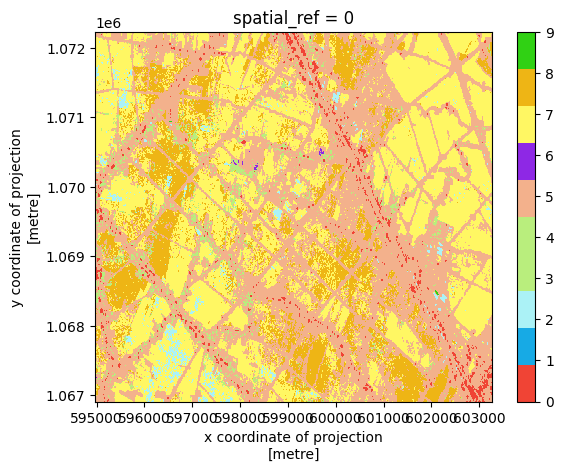

In [93]:
cmap = ListedColormap(colors)
region_result.plot(cmap=cmap)

In [94]:
region_result.rio.to_raster("output_file.tif")

In [9]:
client.close()
cluster.close()